## Plot DETR log

In [1]:
import json
import torch
import matplotlib.pyplot as plt
from PIL import Image
import json
from tqdm import tqdm_notebook
from pathlib import Path
import torchvision
from notebook_utils import *

In [2]:
log_directory = Path('pretrained/radiogalaxy/2021-11-17_r50_150ep')
log_directory_list = [log_directory]
weight_path = log_directory / Path('checkpoint0149.pth')

In [3]:
CLASSES = ['No-Object', 'galaxy', 'source', 'sidelobe']
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556]]
CONFIDENCE_THR = 0.9

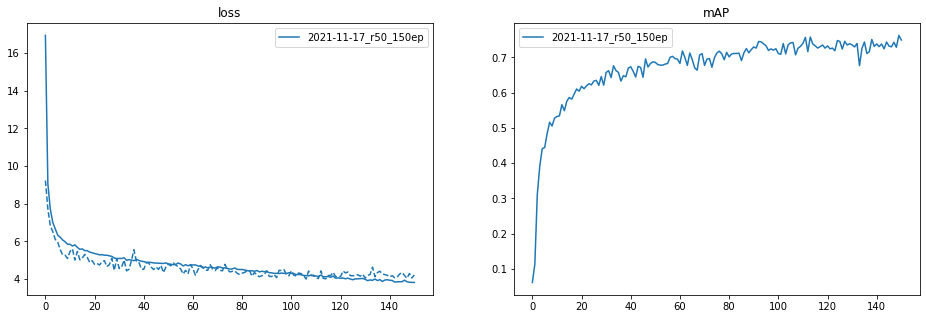

In [4]:
fields_of_interest = (
    'loss',
    'mAP',
    )

plot_logs(log_directory_list,
          fields_of_interest)

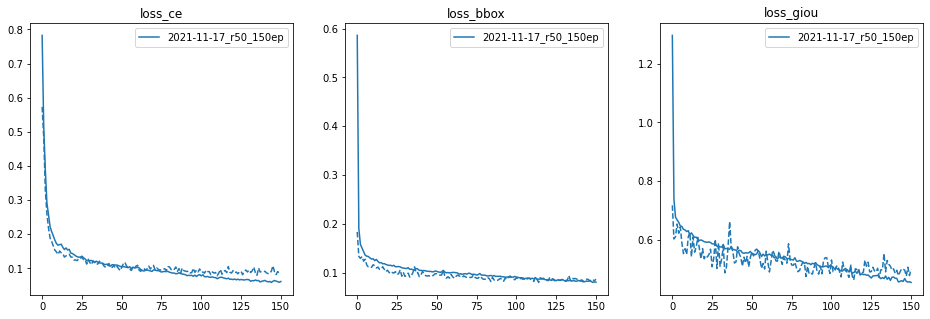

In [5]:
fields_of_interest = (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
    )

plot_logs(log_directory_list,
          fields_of_interest)

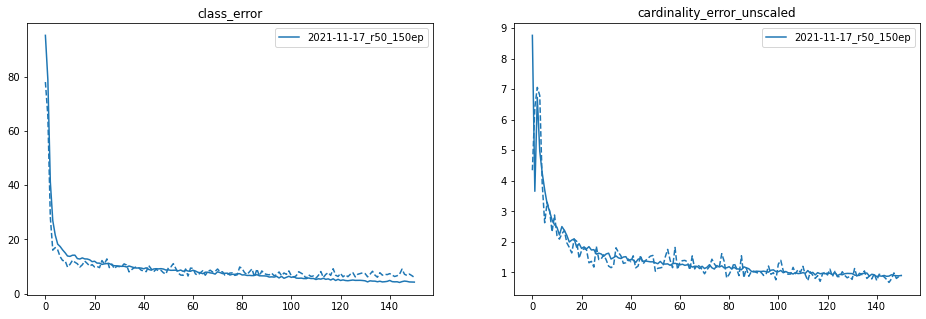

In [6]:
fields_of_interest = (
    'class_error',
    'cardinality_error_unscaled',
    )

plot_logs(log_directory_list,
          fields_of_interest)   

### Load the trained model

In [7]:
num_classes= len(CLASSES)

model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load(weight_path,
                        map_location='cuda')

pretrained = torch.hub.load_state_dict_from_url(
                'https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth', map_location='cuda', check_hash=True)

model.load_state_dict(checkpoint['model'],
                      strict=False)

model = model.cuda()
model.eval()

Using cache found in /home/rensortino/.cache/torch/hub/facebookresearch_detr_master


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_f

In [8]:
out_box_file = log_directory / Path('rg-boxes.json')
no_pred = log_directory / Path('no_pred.txt')
if no_pred.exists():
    no_pred.unlink()

## Visualization functions

In [9]:
test_dir = Path('data/radio-galaxy/test')

In [10]:
def prepare_img(pil_img):
    transforms = make_coco_transforms()
    img, _ = transforms(pil_img, None)
    
    img = img.unsqueeze(0)
    img = img.cuda()
    return img

def run_inference(img, original_size):

    outputs = model(img)
    img = img.squeeze(0)

    labels, pred_boxes, confidence = format_output(outputs, CONFIDENCE_THR, 0)

    if pred_boxes is not None:
        bboxes_scaled = rescale_bboxes(pred_boxes, original_size)
    else:
        return None, None, None
    return labels, bboxes_scaled, confidence

### Run inference on dataset

In [14]:
plt.ioff()
pred_folder_path = Path('predictions')
pred_folder_path.mkdir(exist_ok=True)
out_boxes = {}
batch_idx = 0
from tqdm import tqdm
for img_path in tqdm(test_dir.glob('*[.jpeg .png]')):

    pil_img = Image.open(img_path).convert("RGB")
    img = prepare_img(pil_img)

    # Takes tensor image to run inference on (rescaled image based on training sizes)
    # and original image size
    labels, boxes, confidence = run_inference(img, pil_img.size)

    img_name = img_path.stem

    if labels is None or boxes is None or confidence is None:
        with open(no_pred, 'a') as f:
            f.write(f'No predictions for img {img_name} at score {CONFIDENCE_THR}\n')
        continue
    else:
        out_boxes[img_name] = {}
        out_boxes[img_name]['labels'] = [CLASSES[cl_idx] for cl_idx in labels.tolist()]
        out_boxes[img_name]['boxes'] = boxes.tolist()
        out_boxes[img_name]['scores'] = confidence.tolist()

with open(out_box_file, 'w') as out_json:
    json.dump(out_boxes, out_json)

2235it [02:13, 16.77it/s]


In [12]:
import gc
gc.collect()
torch.cuda.empty_cache() 

## Log single images

In [12]:
with open('data/radio-galaxy/annotations/test.json') as infile:
    annotations = json.load(infile)

with open(out_box_file) as infile:
    pred_boxes = json.load(infile)
    
id_to_filename = {}
for img in annotations['images']:
    id_to_filename[img['id']] = img['file_name'].split('.')[0]

gt_boxes = {}
# placeholder = Image.open('data/radio-galaxy/val/sample1_galaxy0011.png')
for ann in annotations['annotations']:

    img_id = ann['image_id']
    img_name = id_to_filename[img_id]

    w, h = annotations['images'][img_id]['width'], annotations['images'][img_id]['height']

    if img_name not in gt_boxes:
        gt_boxes[img_name] = {'boxes': [], 'labels': []}
    bbox = ann['bbox'].copy()

    bbox[2] += bbox[0]
    bbox[3] += bbox[1]

    # bbox[0] = bbox[0] / w * 800
    # bbox[2] = bbox[2] / w * 800
    # bbox[1] = bbox[1] / h * 800
    # bbox[3] = bbox[3] / h * 800
    
    class_id = ann['category_id']
    gt_boxes[img_name]['boxes'].append(bbox)
    gt_boxes[img_name]['labels'].append(class_id)

In [13]:
import torch
pred_list = []
no_pred = []
for img in sorted(pred_boxes):
    for k, v in pred_boxes[img].items():
        if not isinstance(v, torch.Tensor):
            pred_boxes[img][k] = torch.tensor(v)
    if not pred_boxes[img]:
        # Handle missing predictions
        pred_boxes[img]['boxes'] = torch.tensor([[0.,0.,0.,0.]])
        pred_boxes[img]['labels'] = torch.tensor([0])
        pred_boxes[img]['scores'] = torch.tensor([0.])
    pred_list.append(pred_boxes[img])

gt_list = []

for img in sorted(gt_boxes):
    for k, v in gt_boxes[img].items():
        gt_boxes[img][k] = torch.tensor(v)
    gt_list.append(gt_boxes[img])

In [14]:
len(pred_list)

2235

In [15]:
import torchmetrics
map50 = torchmetrics.MAP(class_metrics=True)
map50.update(pred_list, gt_list)
map50.compute()

/home/rensortino/.local/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


{'map': tensor([0.4333]),
 'map_50': tensor([0.7186]),
 'map_75': tensor([0.4554]),
 'map_small': tensor([0.4325]),
 'map_medium': tensor([0.4687]),
 'map_large': tensor([0.]),
 'mar_1': tensor([0.3044]),
 'mar_10': tensor([0.5240]),
 'mar_100': tensor([0.5260]),
 'mar_small': tensor([0.5220]),
 'mar_medium': tensor([0.5124]),
 'mar_large': tensor([0.]),
 'map_per_class': tensor([-1.0000,  0.6198,  0.4241,  0.2561]),
 'mar_100_per_class': tensor([-1.0000,  0.7031,  0.5206,  0.3543])}

sample18_galaxy0091


KeyError: 'sample18_galaxy0091'

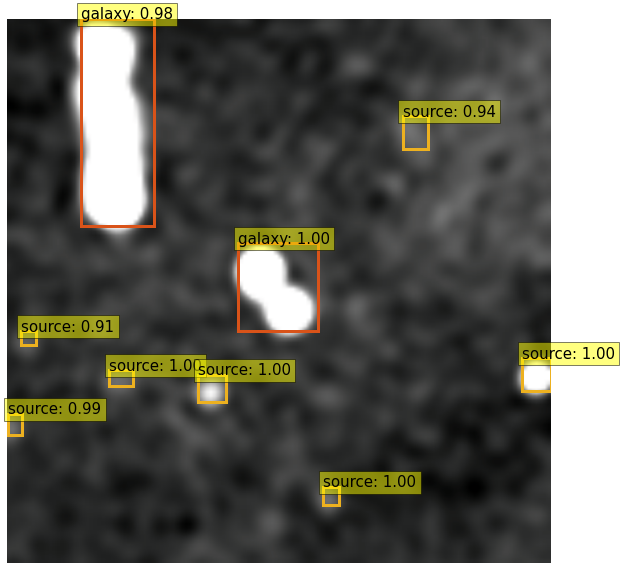

In [80]:
import random
img_path = Path('data/radio-galaxy/val/sample18_galaxy0091.png')
# img_path = random.sample(list(test_dir.glob('*.png')), 1)[0]

batch_idx = 0

img = prepare_img(img_path)
labels, boxes, scores = run_inference(img)

denorm_img = inv_normalize(img.squeeze(0))
orig_image = torchvision.transforms.functional.to_pil_image(denorm_img)


fig = log_image(orig_image, labels, boxes, scores, 'Prediction', CLASSES, COLORS)

img_name = img_path.stem
print(img_name)
gtb, gtl = gt_boxes[img_name].values()
gts = [1] * len(gtl)
fig = log_image(orig_image, gtl, gtb, gts, 'GT', CLASSES, COLORS)

Text(0, 0, 'galaxy: 0.90')

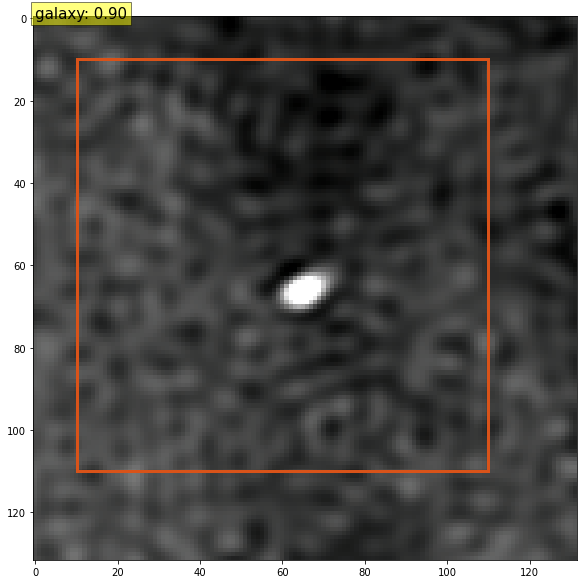

In [59]:
fig = plt.figure(figsize=(16,10))
plt.imshow(orig_image)
ax = plt.gca()

ax.add_patch(plt.Rectangle((10, 10), 100, 100,
                        fill=False, color=COLORS[1], linewidth=3))
text = f'{CLASSES[1]}: {0.9:0.2f}'
ax.text(0, 0, text, fontsize=15,
        bbox=dict(facecolor='yellow', alpha=0.5))
